# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_50', 'ORACLE.run1_26', 'ORACLE.run1_14', 'ORACLE.run1_8', 'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_32', 'ORACLE.run1_20'}


{'CORES_5', 'CORES_2', 'CORES_1', 'CORES_3', 'CORES_4'}


tensor([[[ 3.4791e-03, -1.1292e-03, -1.6480e-03,  ..., -1.6785e-03,
          -2.0447e-03, -6.5615e-03],
         [ 7.0193e-04,  2.0753e-03,  2.1973e-03,  ..., -6.1037e-05,
          -1.0376e-03, -7.0193e-04]],

        [[-5.4933e-04,  7.3244e-04, -7.9348e-04,  ...,  4.2726e-04,
          -1.0987e-03, -1.6785e-03],
         [ 1.1902e-03,  1.4954e-03, -4.0590e-03,  ...,  1.2207e-03,
           7.3244e-04,  1.0376e-03]],

        [[ 1.0681e-03, -4.2726e-04,  3.0519e-05,  ..., -2.1058e-03,
          -1.2818e-03, -2.1058e-03],
         [-2.9298e-03,  2.7467e-04,  1.4344e-03,  ..., -1.7396e-03,
          -2.5636e-03,  2.6246e-03]],

        ...,

        [[ 5.0050e-03,  2.1973e-03,  5.5544e-03,  ..., -2.0142e-03,
          -2.3804e-03, -1.4039e-03],
         [-1.6480e-03,  3.8759e-03,  2.4720e-03,  ..., -3.3265e-03,
           7.9348e-03,  7.5991e-03]],

        [[-4.5778e-04,  5.8290e-03,  1.5259e-04,  ..., -3.0519e-03,
          -8.5452e-04, -6.1037e-04],
         [-6.7141e-04, -2.3499e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.2130, train_label_loss: 2.7066, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2301.5113, train_label_loss: 1.4054, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 2309.4807, train_label_loss: 1.3643, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2313.2164, train_label_loss: 0.9660, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2291.0186, train_label_loss: 1.2472, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2296.7235, train_label_loss: 1.3273, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2331.2096, train_label_loss: 1.0011, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2287.5063, train_label_loss: 1.2580, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2295.7623, train_label_loss: 0.6593, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2364.7014, train_label_loss: 1.1229, 


epoch: 1, source_val_acc_label: 0.6649, target_val_acc_label: 0.8948, source_val_label_loss: 1.0967, target_val_label_loss: 13.3754, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.2791, train_label_loss: 0.8977, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2317.6983, train_label_loss: 0.6120, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2335.5154, train_label_loss: 1.1954, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2337.1572, train_label_loss: 0.4571, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2303.3419, train_label_loss: 0.7256, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2445.3627, train_label_loss: 0.8347, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2610.9734, train_label_loss: 0.5426, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2588.8398, train_label_loss: 0.6679, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2611.9442, train_label_loss: 1.1174, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2669.7751, train_label_loss: 0.9295, 


epoch: 2, source_val_acc_label: 0.7518, target_val_acc_label: 0.9563, source_val_label_loss: 0.7012, target_val_label_loss: 2.9991, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.7713, train_label_loss: 0.5059, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3438.2843, train_label_loss: 0.3809, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2632.8580, train_label_loss: 0.6087, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2646.2292, train_label_loss: 0.4062, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2616.3487, train_label_loss: 0.5436, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2637.9935, train_label_loss: 0.9339, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2673.2367, train_label_loss: 0.9327, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2609.7016, train_label_loss: 0.8006, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2604.8411, train_label_loss: 0.3231, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3017.5284, train_label_loss: 0.3678, 


epoch: 3, source_val_acc_label: 0.7634, target_val_acc_label: 0.9620, source_val_label_loss: 0.6565, target_val_label_loss: 3.2417, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.8630, train_label_loss: 0.7588, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3009.3351, train_label_loss: 0.6614, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2947.5235, train_label_loss: 0.8050, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3025.1031, train_label_loss: 0.8364, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3013.9875, train_label_loss: 0.2094, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2910.0160, train_label_loss: 0.7600, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2416.1221, train_label_loss: 1.0119, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2305.7710, train_label_loss: 0.5219, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2309.6809, train_label_loss: 0.8363, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2321.3978, train_label_loss: 1.1945, 


epoch: 4, source_val_acc_label: 0.7949, target_val_acc_label: 0.9651, source_val_label_loss: 0.5744, target_val_label_loss: 4.9356, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.2692, train_label_loss: 0.3854, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2558.7395, train_label_loss: 0.2084, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2569.4972, train_label_loss: 0.4563, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2799.8272, train_label_loss: 0.5213, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2960.8181, train_label_loss: 0.3386, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3416.4926, train_label_loss: 0.3396, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3005.8762, train_label_loss: 0.3131, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2315.8768, train_label_loss: 0.3740, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2319.8224, train_label_loss: 0.7961, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2319.6794, train_label_loss: 0.4997, 


epoch: 5, source_val_acc_label: 0.8023, target_val_acc_label: 0.9664, source_val_label_loss: 0.5506, target_val_label_loss: 6.3059, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.0745, train_label_loss: 0.4676, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2350.8341, train_label_loss: 0.7515, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2325.4883, train_label_loss: 0.3915, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2424.6357, train_label_loss: 0.3346, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2641.2645, train_label_loss: 0.5057, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2590.2820, train_label_loss: 0.2588, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2568.8279, train_label_loss: 0.2381, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2370.1774, train_label_loss: 0.1835, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2300.9430, train_label_loss: 0.3459, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2324.6353, train_label_loss: 0.4634, 


epoch: 6, source_val_acc_label: 0.8248, target_val_acc_label: 0.9679, source_val_label_loss: 0.5161, target_val_label_loss: 6.0034, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.0630, train_label_loss: 0.3951, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2407.0606, train_label_loss: 0.5594, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2608.5854, train_label_loss: 0.4912, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2648.3076, train_label_loss: 0.4323, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2910.7632, train_label_loss: 0.5285, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2910.1427, train_label_loss: 0.4977, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2904.5905, train_label_loss: 0.1924, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2674.3308, train_label_loss: 0.5106, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2570.8745, train_label_loss: 0.3810, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3001.5886, train_label_loss: 0.0827, 


epoch: 7, source_val_acc_label: 0.8195, target_val_acc_label: 0.9739, source_val_label_loss: 0.5310, target_val_label_loss: 5.5904, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.1137, train_label_loss: 0.5921, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2302.3758, train_label_loss: 0.5641, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2312.6643, train_label_loss: 0.2456, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2333.5768, train_label_loss: 0.4980, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2511.2608, train_label_loss: 0.3706, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2568.6381, train_label_loss: 0.1180, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2556.4001, train_label_loss: 0.2872, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2299.5391, train_label_loss: 0.2717, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2326.8916, train_label_loss: 0.3764, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2306.9867, train_label_loss: 0.2784, 


epoch: 8, source_val_acc_label: 0.8195, target_val_acc_label: 0.9727, source_val_label_loss: 0.5281, target_val_label_loss: 6.7172, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0499, train_label_loss: 0.2131, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2314.7003, train_label_loss: 0.2590, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2305.2914, train_label_loss: 0.4206, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2360.5468, train_label_loss: 0.0742, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2606.1437, train_label_loss: 0.3021, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2590.3623, train_label_loss: 0.3589, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2871.9291, train_label_loss: 0.3851, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2568.8339, train_label_loss: 0.1756, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2591.9758, train_label_loss: 0.1790, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2639.7118, train_label_loss: 0.2624, 


epoch: 9, source_val_acc_label: 0.8242, target_val_acc_label: 0.9797, source_val_label_loss: 0.5509, target_val_label_loss: 5.2385, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.3811, train_label_loss: 0.1150, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3038.8465, train_label_loss: 0.1030, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2455.2208, train_label_loss: 0.0821, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2328.7962, train_label_loss: 0.1201, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2549.1007, train_label_loss: 0.1578, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2718.0130, train_label_loss: 0.2030, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2677.5168, train_label_loss: 0.3140, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2309.5076, train_label_loss: 0.0385, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2313.4746, train_label_loss: 0.5242, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2321.3238, train_label_loss: 0.3746, 


epoch: 10, source_val_acc_label: 0.8202, target_val_acc_label: 0.9786, source_val_label_loss: 0.5419, target_val_label_loss: 5.3496, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.0699, train_label_loss: 0.2490, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2313.4201, train_label_loss: 0.1620, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2326.3203, train_label_loss: 0.1561, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2337.9254, train_label_loss: 0.3471, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2470.1747, train_label_loss: 0.2309, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2586.6490, train_label_loss: 0.2769, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2724.0596, train_label_loss: 0.1519, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2352.0023, train_label_loss: 0.5124, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2302.2201, train_label_loss: 0.1653, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2363.0531, train_label_loss: 0.2001, 


epoch: 11, source_val_acc_label: 0.8220, target_val_acc_label: 0.9796, source_val_label_loss: 0.5785, target_val_label_loss: 6.0391, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.3405, train_label_loss: 0.1830, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2609.1636, train_label_loss: 0.0618, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2606.6707, train_label_loss: 0.1692, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2719.7562, train_label_loss: 0.1941, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3005.2387, train_label_loss: 0.2210, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3488.4413, train_label_loss: 0.0365, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2685.6714, train_label_loss: 0.3621, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2354.8878, train_label_loss: 0.0219, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2338.9352, train_label_loss: 0.1143, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2332.0679, train_label_loss: 0.1203, 


epoch: 12, source_val_acc_label: 0.8193, target_val_acc_label: 0.9792, source_val_label_loss: 0.5713, target_val_label_loss: 6.2631, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.0676, train_label_loss: 0.0345, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2336.9607, train_label_loss: 0.3257, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2308.9679, train_label_loss: 0.1199, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2333.7088, train_label_loss: 0.1382, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2470.1707, train_label_loss: 0.1077, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2641.4275, train_label_loss: 0.2239, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2616.3963, train_label_loss: 0.2521, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2479.7418, train_label_loss: 0.2865, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2326.4700, train_label_loss: 0.2618, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2313.2367, train_label_loss: 0.4502, 


epoch: 13, source_val_acc_label: 0.8197, target_val_acc_label: 0.9819, source_val_label_loss: 0.5758, target_val_label_loss: 5.1638, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.0661, train_label_loss: 0.2160, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2356.0055, train_label_loss: 0.0273, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2632.9846, train_label_loss: 0.2222, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2598.6416, train_label_loss: 0.0956, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2639.1575, train_label_loss: 0.4770, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2928.4991, train_label_loss: 0.0032, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2866.8705, train_label_loss: 0.1687, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 2900.2504, train_label_loss: 0.1304, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 2605.3796, train_label_loss: 0.2457, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 2985.4377, train_label_loss: 0.1826, 


epoch: 14, source_val_acc_label: 0.8200, target_val_acc_label: 0.9820, source_val_label_loss: 0.5829, target_val_label_loss: 5.8506, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.1315, train_label_loss: 0.1890, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2345.2499, train_label_loss: 0.1912, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2372.6196, train_label_loss: 0.2228, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2319.7515, train_label_loss: 0.4152, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2349.7068, train_label_loss: 0.1891, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2543.4853, train_label_loss: 0.2500, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2617.8371, train_label_loss: 0.1977, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2539.9528, train_label_loss: 0.1682, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2313.0629, train_label_loss: 0.2584, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2322.3135, train_label_loss: 0.3803, 


epoch: 15, source_val_acc_label: 0.8160, target_val_acc_label: 0.9818, source_val_label_loss: 0.6135, target_val_label_loss: 5.9090, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.0455, train_label_loss: 0.2158, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2300.2232, train_label_loss: 0.2136, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2329.6593, train_label_loss: 0.2059, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2333.9756, train_label_loss: 0.2426, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2326.1483, train_label_loss: 0.0249, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2733.6475, train_label_loss: 0.3123, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2872.0649, train_label_loss: 0.3204, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2940.4654, train_label_loss: 0.1181, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2642.7456, train_label_loss: 0.3504, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2604.5536, train_label_loss: 0.0573, 


epoch: 16, source_val_acc_label: 0.8172, target_val_acc_label: 0.9838, source_val_label_loss: 0.6065, target_val_label_loss: 5.0184, 


New best


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.4572, train_label_loss: 0.3501, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2680.7990, train_label_loss: 0.0564, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2308.7616, train_label_loss: 0.1463, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2329.0550, train_label_loss: 0.4130, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2332.1991, train_label_loss: 0.1417, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2605.5602, train_label_loss: 0.0375, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2570.0720, train_label_loss: 0.2281, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2587.3017, train_label_loss: 0.0154, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2306.0214, train_label_loss: 0.1780, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2288.0947, train_label_loss: 0.0805, 


epoch: 17, source_val_acc_label: 0.8242, target_val_acc_label: 0.9823, source_val_label_loss: 0.6099, target_val_label_loss: 5.8076, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.0586, train_label_loss: 0.0146, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2323.8319, train_label_loss: 0.2310, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2307.4492, train_label_loss: 0.0427, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2301.3957, train_label_loss: 0.0819, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2299.1155, train_label_loss: 0.0460, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2625.0104, train_label_loss: 0.0495, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2594.0768, train_label_loss: 0.3576, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2661.4592, train_label_loss: 0.0925, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2323.3378, train_label_loss: 0.2301, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2389.0626, train_label_loss: 0.2356, 


epoch: 18, source_val_acc_label: 0.8185, target_val_acc_label: 0.9829, source_val_label_loss: 0.6146, target_val_label_loss: 5.3737, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 2.3208, train_label_loss: 0.1953, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 2594.6888, train_label_loss: 0.6289, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 2609.0039, train_label_loss: 0.2870, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 2594.7238, train_label_loss: 0.2167, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 2861.6187, train_label_loss: 0.3275, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2910.9644, train_label_loss: 0.1353, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2571.4417, train_label_loss: 0.0615, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 2641.4414, train_label_loss: 0.0058, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 2329.6782, train_label_loss: 0.3003, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 2322.9367, train_label_loss: 0.0787, 


epoch: 19, source_val_acc_label: 0.8213, target_val_acc_label: 0.9824, source_val_label_loss: 0.6313, target_val_label_loss: 5.3993, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 2.0571, train_label_loss: 0.0316, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 2315.7009, train_label_loss: 0.0270, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 2305.9301, train_label_loss: 0.4918, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 2308.4350, train_label_loss: 0.0143, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 2311.9708, train_label_loss: 0.3920, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 2539.6065, train_label_loss: 0.5121, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 2653.1752, train_label_loss: 0.1740, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 2633.8053, train_label_loss: 0.2868, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 2622.4381, train_label_loss: 0.0665, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 2727.4492, train_label_loss: 0.1839, 


epoch: 20, source_val_acc_label: 0.8183, target_val_acc_label: 0.9839, source_val_label_loss: 0.6316, target_val_label_loss: 5.2117, 


New best


epoch: 21, [batch: 1 / 6720], examples_per_second: 2.3601, train_label_loss: 0.3259, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 2901.7080, train_label_loss: 0.1380, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 2912.0552, train_label_loss: 0.6665, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 2897.4857, train_label_loss: 0.3952, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3094.9024, train_label_loss: 0.0004, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3373.5923, train_label_loss: 0.1759, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3525.1131, train_label_loss: 0.1504, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3357.5595, train_label_loss: 0.2317, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 3816.9082, train_label_loss: 0.0044, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 3544.4873, train_label_loss: 0.0036, 


epoch: 21, source_val_acc_label: 0.8196, target_val_acc_label: 0.9831, source_val_label_loss: 0.6418, target_val_label_loss: 5.0357, 


epoch: 22, [batch: 1 / 6720], examples_per_second: 2.8088, train_label_loss: 0.1804, 


epoch: 22, [batch: 672 / 6720], examples_per_second: 2997.8261, train_label_loss: 0.3474, 


epoch: 22, [batch: 1344 / 6720], examples_per_second: 2595.8860, train_label_loss: 0.0209, 


epoch: 22, [batch: 2016 / 6720], examples_per_second: 2331.2206, train_label_loss: 0.1199, 


epoch: 22, [batch: 2688 / 6720], examples_per_second: 2280.7328, train_label_loss: 0.4650, 


epoch: 22, [batch: 3360 / 6720], examples_per_second: 2300.1818, train_label_loss: 0.5282, 


epoch: 22, [batch: 4032 / 6720], examples_per_second: 2315.4235, train_label_loss: 0.1573, 


epoch: 22, [batch: 4704 / 6720], examples_per_second: 2297.5286, train_label_loss: 0.0026, 


epoch: 22, [batch: 5376 / 6720], examples_per_second: 2311.9845, train_label_loss: 0.2792, 


epoch: 22, [batch: 6048 / 6720], examples_per_second: 2304.3932, train_label_loss: 0.0512, 


epoch: 22, source_val_acc_label: 0.8186, target_val_acc_label: 0.9833, source_val_label_loss: 0.6790, target_val_label_loss: 5.3086, 


epoch: 23, [batch: 1 / 6720], examples_per_second: 2.1264, train_label_loss: 0.3349, 


epoch: 23, [batch: 672 / 6720], examples_per_second: 2605.3811, train_label_loss: 0.3862, 


epoch: 23, [batch: 1344 / 6720], examples_per_second: 2579.1473, train_label_loss: 0.0707, 


epoch: 23, [batch: 2016 / 6720], examples_per_second: 2339.0498, train_label_loss: 0.1316, 


epoch: 23, [batch: 2688 / 6720], examples_per_second: 2320.5160, train_label_loss: 0.0343, 


epoch: 23, [batch: 3360 / 6720], examples_per_second: 2624.3446, train_label_loss: 0.3266, 


epoch: 23, [batch: 4032 / 6720], examples_per_second: 2574.9885, train_label_loss: 0.0709, 


epoch: 23, [batch: 4704 / 6720], examples_per_second: 2603.6643, train_label_loss: 0.0097, 


epoch: 23, [batch: 5376 / 6720], examples_per_second: 2581.2986, train_label_loss: 0.1734, 


epoch: 23, [batch: 6048 / 6720], examples_per_second: 2626.7058, train_label_loss: 0.0772, 


epoch: 23, source_val_acc_label: 0.8142, target_val_acc_label: 0.9831, source_val_label_loss: 0.6741, target_val_label_loss: 5.0368, 


epoch: 24, [batch: 1 / 6720], examples_per_second: 2.5810, train_label_loss: 0.1551, 


epoch: 24, [batch: 672 / 6720], examples_per_second: 2953.7947, train_label_loss: 0.0141, 


epoch: 24, [batch: 1344 / 6720], examples_per_second: 2504.5840, train_label_loss: 0.1041, 


epoch: 24, [batch: 2016 / 6720], examples_per_second: 2298.2412, train_label_loss: 0.0240, 


epoch: 24, [batch: 2688 / 6720], examples_per_second: 2301.6986, train_label_loss: 0.1978, 


epoch: 24, [batch: 3360 / 6720], examples_per_second: 2324.5366, train_label_loss: 0.0076, 


epoch: 24, [batch: 4032 / 6720], examples_per_second: 2311.2333, train_label_loss: 0.3196, 


epoch: 24, [batch: 4704 / 6720], examples_per_second: 2299.9891, train_label_loss: 0.0630, 


epoch: 24, [batch: 5376 / 6720], examples_per_second: 2313.9927, train_label_loss: 0.0886, 


epoch: 24, [batch: 6048 / 6720], examples_per_second: 2302.6088, train_label_loss: 0.2078, 


epoch: 24, source_val_acc_label: 0.8071, target_val_acc_label: 0.9819, source_val_label_loss: 0.6796, target_val_label_loss: 5.6540, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

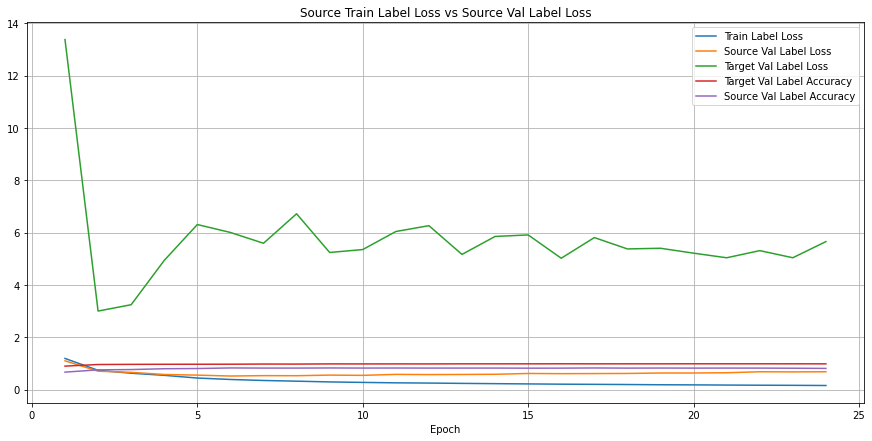

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

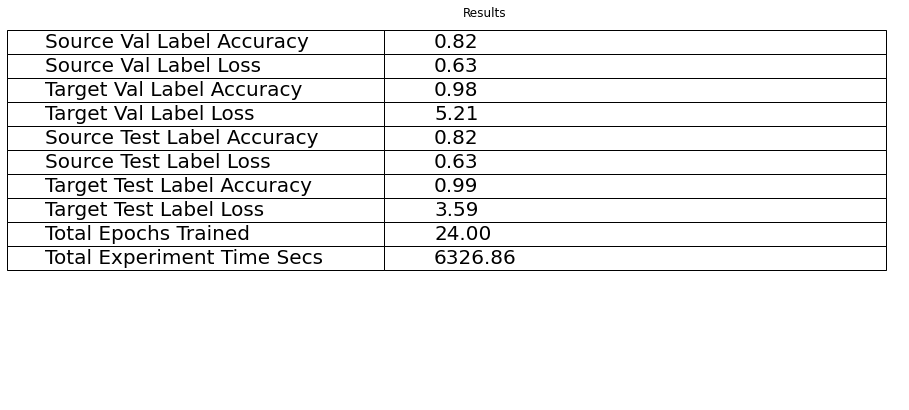

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

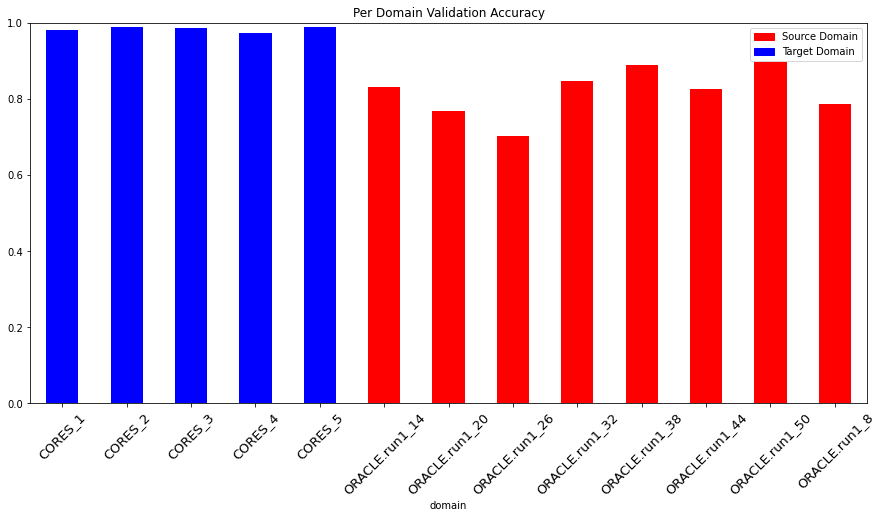

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.816796875 Target Test Label Accuracy: 0.9867424242424242
Source Val Label Accuracy: 0.8182942708333333 Target Val Label Accuracy: 0.9838755707762558


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}